### Star Wars Legos Image Classification with total five classes using Convolutional Neural Networks

In [1]:
# Importing necessary libraries
import os
import math
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
BASE_DIR = "/content/drive/MyDrive/Data Science WorkSpace/Tensorflow tutorials/Lego MiniFigures Image Classification/star-wars-images/"
names = ['YODA', 'LUKE SKYWALKER', 'R2-D2', 'MACE WINDU', 'GENERAL GRIEVOUS']
tf.random.set_seed(1)

In [3]:
# Creation of test, train and validation datasets
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [4]:
# Total number of classes in the dataset
orig_folders = ["0001/", "0002/", "0003/", "0004/", "0005/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.6) + 0.5)
    n_valid = int((number_of_images * 0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + 'train/' + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + 'val/' + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + 'test/' + names[folder_idx])

12 7 3 2
12 7 3 2
12 7 3 2
13 8 3 2
14 8 4 2


In [18]:
# Generate batches of tensor image data with real-time data augmentation

#preprocessing function
# rescale = 1./255
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)                                                         
valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(
    BASE_DIR + '/train',
    target_size=(256, 256),
    class_mode = 'sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

val_batches = valid_gen.flow_from_directory(
    BASE_DIR + '/val',
    target_size=(256, 256),
    class_mode = 'sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    BASE_DIR + '/test',
    target_size=(256, 256),
    class_mode = 'sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names 
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [19]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])
test_batch = test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[0. 4. 3. 3.]
(4, 256, 256, 3)
[0. 0. 1. 1.]


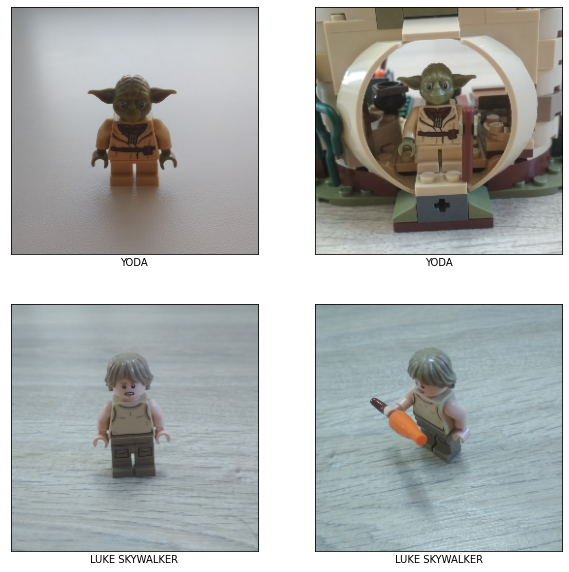

In [20]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays, hence need of extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

show(test_batch)

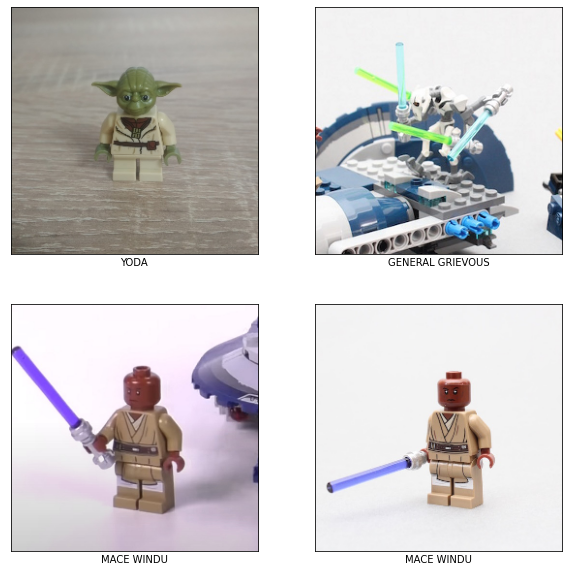

In [21]:
show(train_batch)

In [33]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides = (1,1), padding="valid", activation="relu", input_shape=(256, 256, 3)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(5))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 246016)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [35]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ['accuracy']
model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [36]:
# training
epochs = 30

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=2
)

history = model.fit(train_batches, validation_data = val_batches, 
                    callbacks = [early_stopping],
                    epochs = epochs, verbose=2)

Epoch 1/30
10/10 - 5s - loss: 4.5334 - accuracy: 0.1892 - val_loss: 1.6209 - val_accuracy: 0.2500 - 5s/epoch - 521ms/step
Epoch 2/30
10/10 - 4s - loss: 1.6225 - accuracy: 0.2162 - val_loss: 1.5998 - val_accuracy: 0.2500 - 4s/epoch - 442ms/step
Epoch 3/30
10/10 - 4s - loss: 1.4519 - accuracy: 0.4324 - val_loss: 1.5863 - val_accuracy: 0.3125 - 4s/epoch - 447ms/step
Epoch 4/30
10/10 - 4s - loss: 1.0288 - accuracy: 0.6757 - val_loss: 1.7909 - val_accuracy: 0.3125 - 4s/epoch - 444ms/step
Epoch 5/30
10/10 - 4s - loss: 0.7038 - accuracy: 0.8649 - val_loss: 1.6430 - val_accuracy: 0.4375 - 4s/epoch - 449ms/step
Epoch 6/30
10/10 - 4s - loss: 0.4675 - accuracy: 0.9189 - val_loss: 2.0055 - val_accuracy: 0.5000 - 4s/epoch - 444ms/step
Epoch 7/30
10/10 - 4s - loss: 1.2653 - accuracy: 0.8378 - val_loss: 1.6690 - val_accuracy: 0.5000 - 4s/epoch - 449ms/step
Epoch 8/30
10/10 - 4s - loss: 0.6038 - accuracy: 0.8919 - val_loss: 2.0915 - val_accuracy: 0.5625 - 4s/epoch - 443ms/step
Epoch 8: early stopping


In [37]:
# save the model
model.save("lego_model.h5")

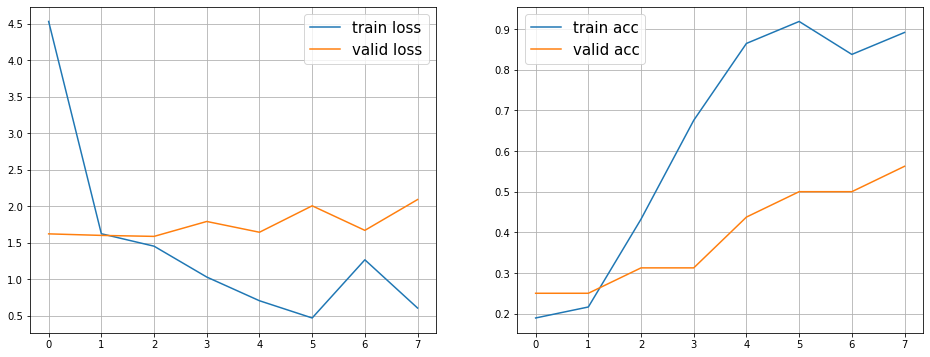

In [38]:
# plot loss and accuracy
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15);

In [39]:
model.evaluate(test_batches, verbose=2)

3/3 - 3s - loss: 1.2892 - accuracy: 0.5000 - 3s/epoch - 834ms/step


[1.2892038822174072, 0.5]

In [42]:
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

[0. 0. 1. 1.]
[1 4 1 4]


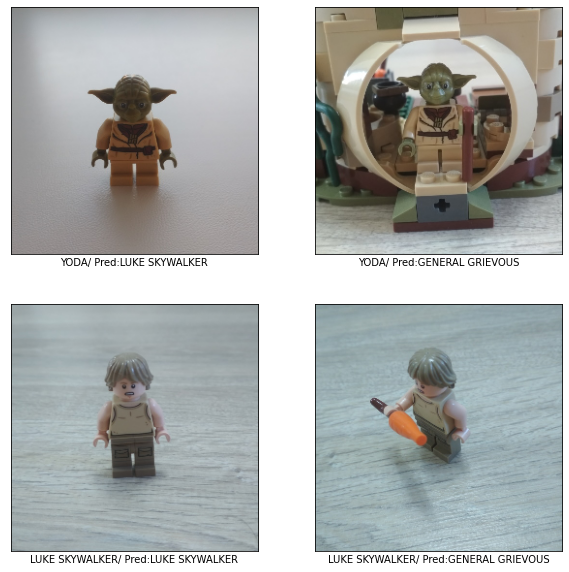

In [43]:
show(test_batches[0], labels[0:4])